# Bias Variance

![title](images/ml_bias_variance.png)

Мы не будем выписывать строгие формулы, но попробуем объяснить идею этих понятий.

Пусть у нас есть алгоритм обучения, который по данным может создать модель.

Ошибка этих моделей может быть разложена на три части:
* **Noise** – шум данных, не предсказуем, теоретический минимум ошибки
* **Bias** – смещение, на сколько хорошо работает средний алгоритм. Средний алгоритм это "возьмём случайные данные, обучим алгоритм, сделаем предсказания", **Bias** – это ошибка средних предсказаний.
* **Variance** – разброс, на сколько устойчиво работает алгоритм. Опять же "возьмём случайные данные, обучим алгоритм, сделаем предсказания", **Variance** – это разрос этих предсказаний.

# Бустинг и Бэггинг в терминах Bias и Variance

Как вы думаете на какую составляющую Бустинг и Бэггинг влияют, а на какую нет?

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/Users/tylorn/envs/dmia2019/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = pd.read_csv('data/HR.csv')

In [3]:
data.head()

,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
0,0.53,2,157,3,0,1,0
1,0.86,5,262,6,0,0,0
2,0.88,7,272,4,0,1,0
3,0.87,5,223,5,0,1,0
4,0.52,2,159,3,0,1,0


In [4]:
class_names = ['stayed', 'left']
X, y = data.drop('left', axis=1).values, data['left'].values

In [5]:
np.unique(y)

array([0, 1])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, shuffle=True)
class_names = ['stayed', 'left']

In [7]:
svd_transformer = TruncatedSVD()
X_train = svd_transformer.fit_transform(X_train)
X_test = svd_transformer.transform(X_test)

In [8]:
X_train.shape, X_test.shape

((14849, 2), (150, 2))

In [9]:
def plot_decision_surface(model, X, y):
    
    """Function to plot the decision boundaries of a classification model.
    
    Adopted from:
    http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
    http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
    """

    plt.figure(figsize=(8,6))
    plt.subplot(1, 1, 1)

    n_classes = 2
    plot_step = 0.02
    plot_colors = ['white', 'tab:blue']
    cmap = plt.cm.Blues

    d0, d1 = (X[:, 0].max() - X[:, 0].min()) * 0.1, (X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - d0, X[:, 0].max() + d0
    y_min, y_max = X[:, 1].min() - d1, X[:, 1].max() + d1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], cmap=cmap, label=class_names[i],
                    edgecolor='black', s=90, color=color)

    plt.suptitle("Decision surface of a decision tree using paired features")
    plt.legend(loc='lower right', borderpad=0, handletextpad=0)
    plt.axis("tight")
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    return plt

In [10]:
def sample_model(seed, model):
    random_gen = np.random.RandomState(seed)
    indices = random_gen.choice(len(y_train), size=len(y_train), replace=True)
    model.fit(X_train[indices, :], y_train[indices])
    return model

def estimate_bias_variance(model, iters_count=100):
    y_preds = []
    for seed in range(iters_count):
        model = sample_model(seed, model)
        y_preds.append(model.predict_proba(X_test)[:, 1])
    y_preds = np.array(y_preds)
    
    print('Bias:', np.mean((y_test - y_preds.mean(axis=0)) ** 2))
    print('Variance:', y_preds.std(axis=0).mean())
    est = model.fit(X_train, y_train)
    plot_decision_surface(est, X_test, y_test)

**Линейная модель**

Bias: 0.22751192169742174
Variance: 0.006849552575485723


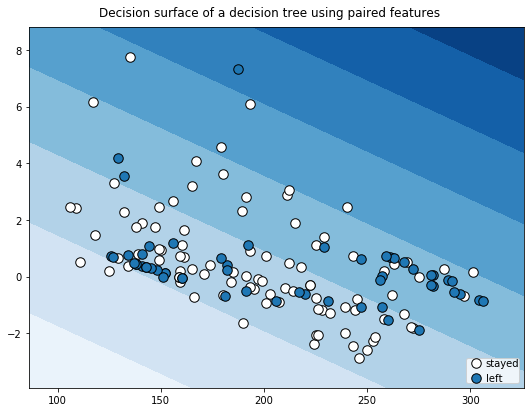

In [11]:
estimate_bias_variance(LogisticRegression())

**Решающее дерево с max_depth=5**

Bias: 0.1947678161345059
Variance: 0.04521438650733994


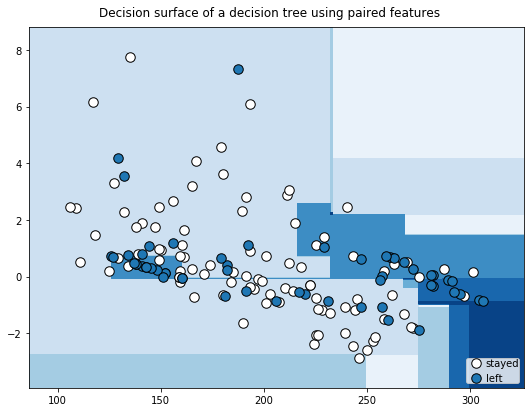

In [12]:
estimate_bias_variance(DecisionTreeClassifier(max_depth=5))

**Решающее дерево с max_depth=10**

Bias: 0.19538377187616196
Variance: 0.11703717292821612


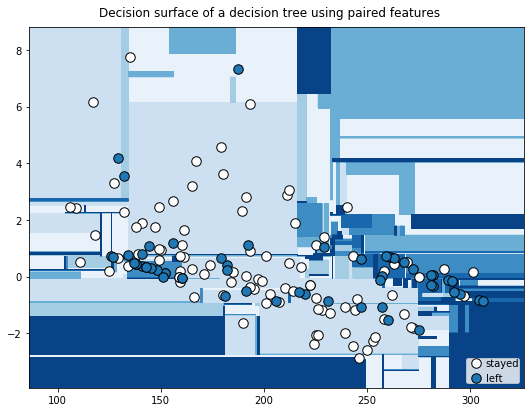

In [13]:
estimate_bias_variance(DecisionTreeClassifier(max_depth=10))

**Решающее дерево с max_depth=15**

Bias: 0.21300690788430401
Variance: 0.18203923196968147


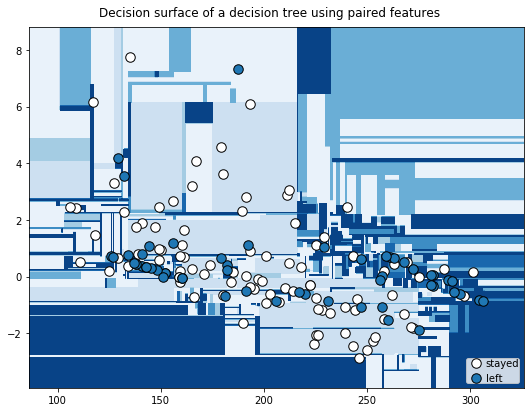

In [14]:
estimate_bias_variance(DecisionTreeClassifier(max_depth=15))

**Решающее дерево без ограничения глубины**

Bias: 0.25128641832207343
Variance: 0.2295665215516434


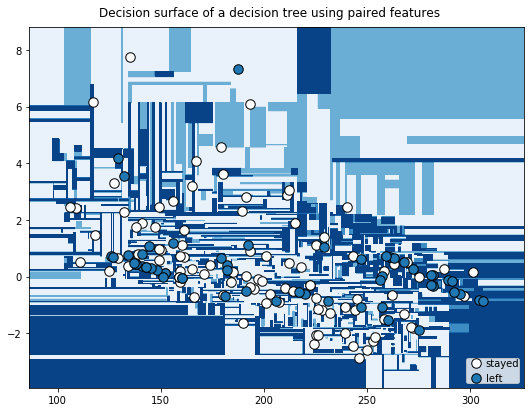

In [15]:
estimate_bias_variance(DecisionTreeClassifier(max_depth=None))

**Случайный лес n_estimators=1**

Bias: 0.2342055438973378
Variance: 0.2882836006456307


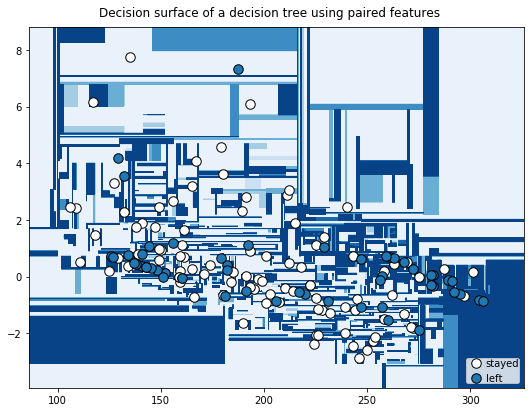

In [16]:
estimate_bias_variance(RandomForestClassifier(n_estimators=1, random_state=42))

**Случайный лес n_estimators=10**

Bias: 0.2311382013313557
Variance: 0.16402821833655865


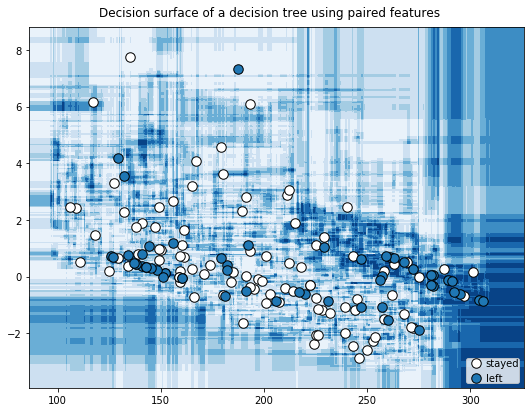

In [17]:
estimate_bias_variance(RandomForestClassifier(n_estimators=10, random_state=42))

**Случайный лес n_estimators=50**

Bias: 0.23077980128797151
Variance: 0.14511358918185546


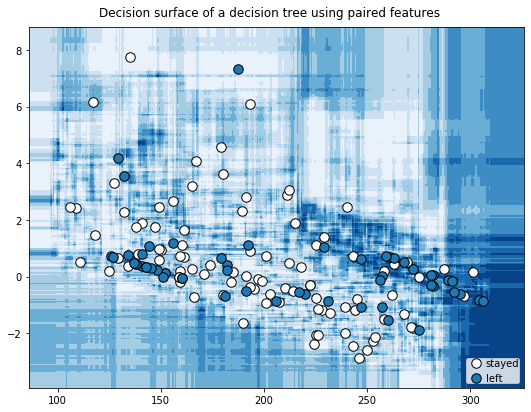

In [18]:
estimate_bias_variance(RandomForestClassifier(n_estimators=50, random_state=42))

**LGBMRegressor**

Bias: 0.22053005782040677
Variance: 0.006245641856674707


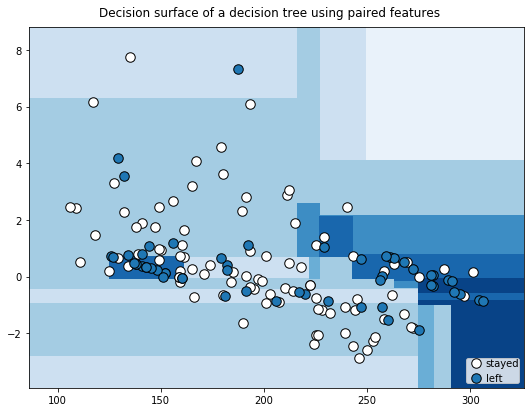

In [19]:
estimate_bias_variance(LGBMClassifier(n_estimators=1, max_depth=5))

Bias: 0.195978385510415
Variance: 0.022087791997794537


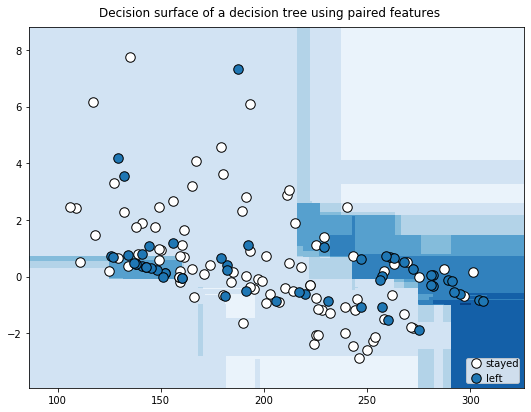

In [20]:
estimate_bias_variance(LGBMClassifier(n_estimators=10, max_depth=5))

Bias: 0.193253946206485
Variance: 0.05216334203278154


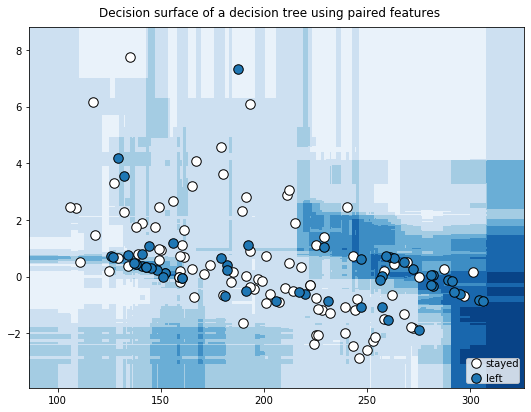

In [21]:
estimate_bias_variance(LGBMClassifier(n_estimators=100, max_depth=5))